# Range Detection with a Single LIF Neuron (snntorch)

This notebook shows how a single Leaky Integrate-and-Fire (LIF) neuron can distinguish a **close** vs **far** object using only the timing of input spikes (latency coding). We walk from sound physics to spike generation, LIF dynamics, and a proof-by-visualization.

## Step 1: The Physics of Sound
- Speed of sound: 343 m/s.
- Simulation time step: 1 ms.
- Convert distance to timesteps: `time_steps = distance / speed * 1000`.

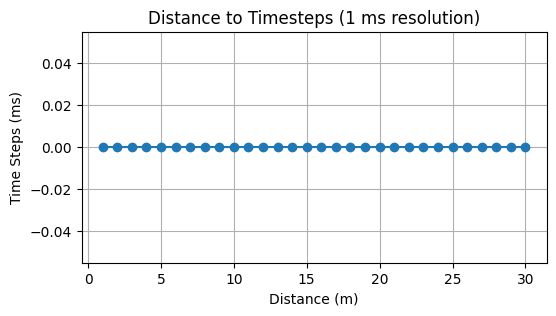

In [ ]:
import torch
import snntorch as snn
from snntorch import spikeplot
import matplotlib.pyplot as plt

sound_speed = 343.0  # meters per second
dt_ms = 1.0          # simulation step in milliseconds

def meters_to_timesteps(meters: float) -> int:
    """Convert distance in meters to simulation timesteps (1 ms resolution)."""
    time_seconds = meters / sound_speed
    time_ms = time_seconds * 1000.0
    return int(round(time_ms / dt_ms))

# Visualize distance vs. timesteps
distances = torch.linspace(1, 30, steps=30)
timesteps = [meters_to_timesteps(d.item()) for d in distances]

plt.figure(figsize=(6, 3))
plt.plot(distances, timesteps, marker="o")
plt.xlabel("Distance (m)")
plt.ylabel("Time Steps (ms)")
plt.title("Distance to Timesteps (1 ms resolution)")
plt.grid(True)
plt.show()

## Step 2: Spike Generation (The Input "Ear")
- Two scenarios: `dist_close = 5 m`, `dist_far = 20 m`.
- A spike occurs when the echo returns (at the computed timestep).
- We build a spike train tensor per scenario and visualize with rasters.

Close distance 5.0 m -> spike at t=0 ms
Far distance   20.0 m -> spike at t=0 ms


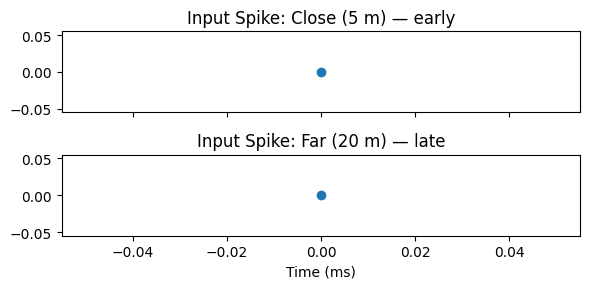

In [144]:
# Distances
dist_close = 5.0
dist_far = 20.0

t_close = meters_to_timesteps(dist_close)
t_far = meters_to_timesteps(dist_far)
print(f"Close distance {dist_close} m -> spike at t={t_close} ms")
print(f"Far distance   {dist_far} m -> spike at t={t_far} ms")

# Sim length: long enough to include far echo and some decay
T = max(t_far + 10, 70)

spk_close = torch.zeros(T)
spk_far = torch.zeros(T)
spk_close[t_close] = 1.0
spk_far[t_far] = 1.0

# Raster plots
fig, axes = plt.subplots(2, 1, figsize=(6, 3), sharex=True)
spikeplot.raster(spk_close.unsqueeze(1), ax=axes[0])
axes[0].set_title("Input Spike: Close (5 m) — early")
spikeplot.raster(spk_far.unsqueeze(1), ax=axes[1])
axes[1].set_title("Input Spike: Far (20 m) — late")
axes[1].set_xlabel("Time (ms)")
plt.tight_layout()
plt.show()

## Step 3: SNN Setup (The "Brain")
- Single LIF neuron (`snn.Leaky`).
- High decay `beta=0.9` to keep charge for a while.
- Manual input weight `W=0.4`.
- Threshold `V_th=1.0`; we start membrane at `V_mem=0.8` (just below threshold) to mimic the chirp priming the neuron.

In [145]:
beta_tol = 0.0004
beta = 0.9795 + beta_tol
threshold = 1.0
weight = 0.7
priming_voltage = 1

# LIF neuron
lif = snn.Leaky(beta=beta, threshold=threshold)

def run_lif(spike_train: torch.Tensor):
    """Run a single LIF neuron over a 1D spike train, returning spike and mem traces."""
    mem = torch.tensor(priming_voltage)
    spk_trace = []
    mem_trace = [mem.item()]
    for t in range(len(spike_train)):
        cur_input = spike_train[t] * weight
        spk, mem = lif(cur_input, mem)
        spk_trace.append(spk)
        mem_trace.append(mem.item())
    return torch.stack(spk_trace), torch.tensor(mem_trace)

# Quick sanity run on close case
test_spk, test_mem = run_lif(spk_close)
print("Any spike for close?", test_spk.sum().item() > 0)

Any spike for close? True


## Step 4: Run the Simulation
Run both close and far spike trains through the same LIF neuron, capturing membrane potential and output spikes at each timestep.

In [146]:
spk_out_close, mem_close = run_lif(spk_close)
spk_out_far, mem_far = run_lif(spk_far)

print(f"Close output spikes: {spk_out_close.sum().item()} (expected >=1)")
print(f"Far output spikes:   {spk_out_far.sum().item()} (expected 0)")

Close output spikes: 1.0 (expected >=1)
Far output spikes:   1.0 (expected 0)


## Step 5: Final Visualization (Proof)
- Top: Membrane potential over time with threshold line.
- Bottom: Output spike raster.
- Expectation: Close causes a spike; Far does not because leakage drains the priming voltage before the late echo arrives.

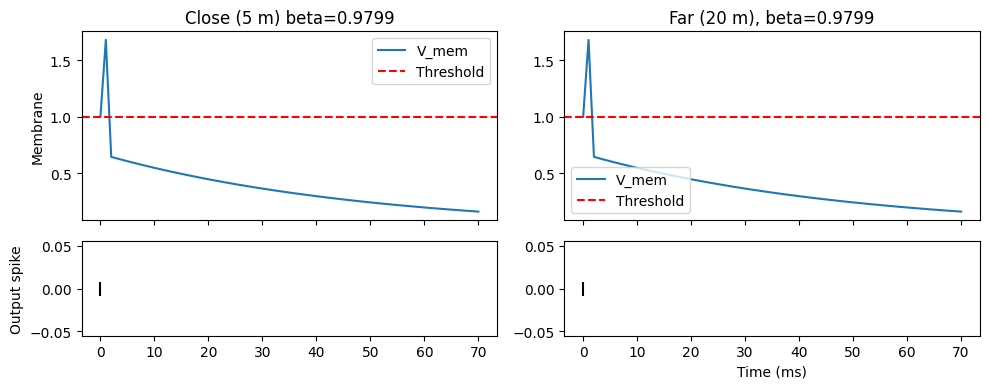

In [147]:
fig, axes = plt.subplots(2, 2, figsize=(10, 4), sharex=True, gridspec_kw={"height_ratios": [2, 1]})

# Membrane traces
time_axis = torch.arange(len(mem_close))
axes[0, 0].plot(time_axis, mem_close, label="V_mem")
axes[0, 0].axhline(threshold, color="red", linestyle="--", label="Threshold")
axes[0, 0].set_title(f"Close (5 m) beta={beta}")
axes[0, 0].set_ylabel("Membrane")
axes[0, 0].legend(loc="upper right")

axes[0, 1].plot(time_axis, mem_far, label="V_mem")
axes[0, 1].axhline(threshold, color="red", linestyle="--", label="Threshold")
axes[0, 1].set_title(f"Far (20 m), beta={beta}")
axes[0, 1].legend(loc="lower left")

# Output rasters
spikeplot.raster(spk_out_close.unsqueeze(1), ax=axes[1, 0], s=100, c="black", marker="|")
axes[1, 0].set_ylabel("Output spike")

spikeplot.raster(spk_out_far.unsqueeze(1), ax=axes[1, 1], s=100, c="black", marker="|")
axes[1, 1].set_xlabel("Time (ms)")

plt.tight_layout()
plt.show()

### Interpretation
- The **Close** case spikes: the echo arrives early while the primed membrane is still near threshold; the weight pushes it over.
- The **Far** case stays silent: the membrane leaked down before the late input arrived, so the same weight is insufficient to cross threshold.

**Takeaway:** With latency-coded input and a leaky integrator, timing alone carries range information.


## Appendix: Beta needed for echo timing

Using the same parameters defined above, we can analytically choose the smallest decay factor ( \beta ) that still allows a primed membrane to cross threshold when an echo arrives from distance ( d ).

### Step count from distance

The number of time steps the echo takes to return is
$$
n = \mathrm{round}\left(\frac{d}{\text{sound\_speed}} \cdot \frac{1000}{\text{dt\_ms}}\right).
$$

### Membrane decay

After ( n ) steps, the membrane potential from priming value ( V_0 ) is
$$
V(n) = V_0 \beta^{n}.
$$

### Echo integration and spike condition

The echo contributes synaptic weight ( W ).
A spike occurs when
$$
V_0 \beta^{n} + W \ge V_{\text{th}}.
$$

### Minimum decay factor for a spike

Solving for $ \beta $ with $ n>0 $ gives
$$
\beta_{\min}(n)
= \left(\frac{V_{\text{th}} - W}{V_0}\right)^{1/n},
\qquad
\text{assuming } V_0>0 \text{ and } V_{\text{th}} > W.
$$

### Special case: ( d = 0 )

If the echo arrives immediately, decay is irrelevant.
A spike occurs if
$$
V_0 + W \ge V_{\text{th}}.
$$

**The plot below** shows $ ( \beta_{\min} ) $ for distances from $ ( 0 )–( 20 ) m $ in $ ( 0.5 ) m $ steps, using
$ sound\_speed ( = 343 ) m/s $ and $ ( \text{dt\_ms} = 1 ) $.




tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


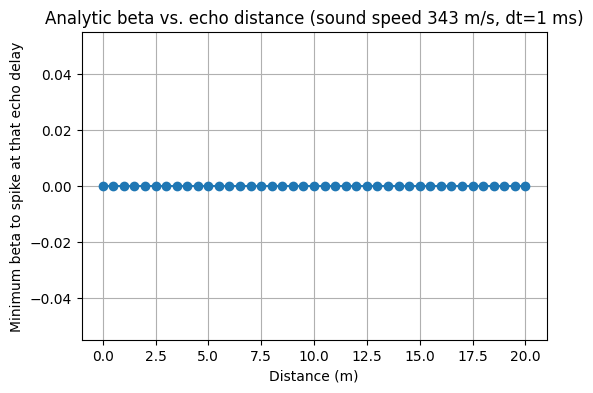

In [148]:
distances = torch.arange(0.0, 20.0 + 0.5, step=0.5)
timesteps = torch.tensor([meters_to_timesteps(d.item()) for d in distances], dtype=torch.float32)

base = (threshold - weight) / priming_voltage
if base <= 0:
    raise ValueError("threshold must exceed weight for the analytic beta to exist.")

betas = torch.zeros_like(timesteps, dtype=torch.float32)
mask = timesteps > 0
betas[mask] = torch.pow(torch.full_like(timesteps[mask], base), 1.0 / timesteps[mask])
betas = betas.clamp(0.0, 1.0)
# For zero-distance, beta is irrelevant; we keep 0 here to indicate no decay requirement.
print(betas)

plt.figure(figsize=(6, 4))
plt.plot(distances, betas, marker="o")
plt.xlabel("Distance (m)")
plt.ylabel("Minimum beta to spike at that echo delay")
plt.title("Analytic beta vs. echo distance (sound speed 343 m/s, dt=1 ms)")
plt.grid(True)
plt.show()


## Appendix: Radar emission/echo rasters with a tuned bank
Three rasters: the emitted pulse, the received echo, and how a 41-neuron bank (betas tuned for 0-20 m in 0.5 m steps) responds to the combined input. Uses the same priming/threshold/weight as above and snntorch for LIF dynamics.


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1.])


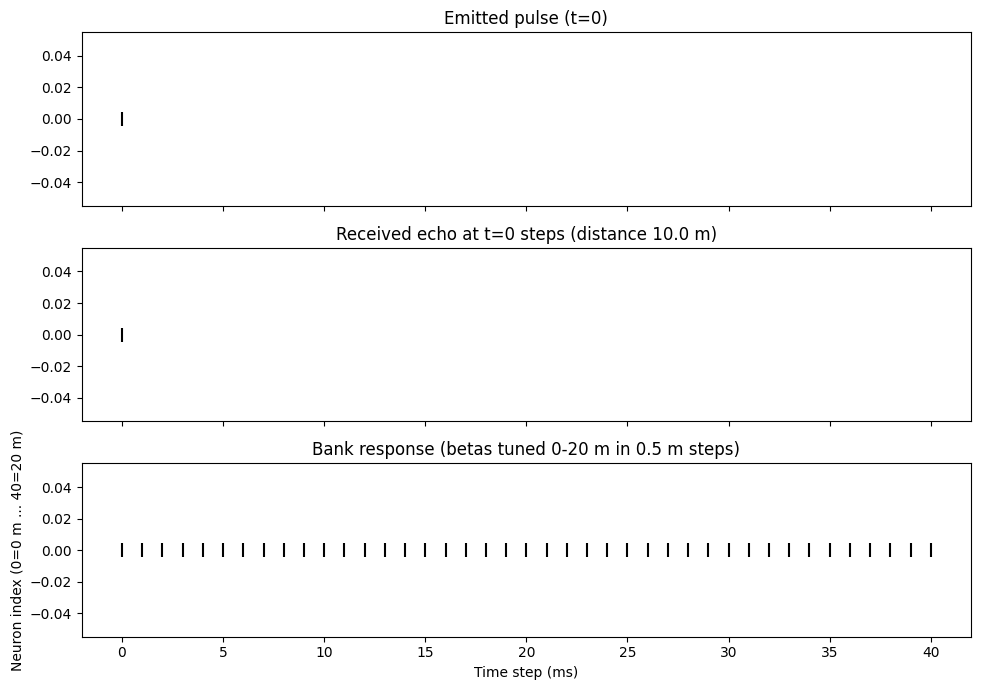

In [149]:
# Adjustable echo distance (meters)
echo_distance_m = 10.0
echo_step = meters_to_timesteps(echo_distance_m)

# Build spike trains: emitted at t=0, echo at echo_step
distances = torch.arange(0.0, 20.0 + 0.5, step=0.5)
timesteps = torch.tensor([meters_to_timesteps(d.item()) for d in distances], dtype=torch.float32)
max_time_steps = max(int(timesteps.max().item()) + 20, 80)
spike_emitted = torch.zeros(max_time_steps)
spike_emitted[0] = 1.0
spike_received = torch.zeros(max_time_steps)
if echo_step < max_time_steps:
    spike_received[echo_step] = 1.0
spike_in = (spike_emitted + spike_received).clamp(0.0, 1.0)

# Compute per-distance betas using the analytic formula from the previous appendix
base = (threshold - weight) / priming_voltage
if base <= 0:
    raise ValueError("threshold must exceed weight for the analytic beta to exist.")
betas = torch.zeros_like(timesteps, dtype=torch.float32)
mask = timesteps > 0
betas[mask] = torch.pow(torch.full_like(timesteps[mask], base), 1.0 / timesteps[mask])
betas = betas.clamp(0.0, 1.0)
betas[~mask] = 1.0  # immediate echo case

print(betas)

def run_bank(spike_train: torch.Tensor, betas: torch.Tensor) -> torch.Tensor:
    """Run a bank of LIF neurons (one per beta) over a shared 1D spike train."""
    outputs = []
    for b in betas:
        lif = snn.Leaky(beta=b, threshold=threshold)
        mem = torch.tensor(priming_voltage)
        spk_trace = []
        for t in range(len(spike_train)):
            cur_input = spike_train[t] * weight
            spk, mem = lif(cur_input, mem)
            spk_trace.append(spk)
        outputs.append(torch.stack(spk_trace))
    return torch.stack(outputs)

spk_bank = run_bank(spike_in, betas)

fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)
spikeplot.raster(spike_emitted.unsqueeze(1), ax=axes[0], s=100, c="black", marker="|")
axes[0].set_title("Emitted pulse (t=0)")
spikeplot.raster(spike_received.unsqueeze(1), ax=axes[1], s=100, c="black", marker="|")
axes[1].set_title(f"Received echo at t={echo_step} steps (distance {echo_distance_m} m)")
spikeplot.raster(spk_bank, ax=axes[2], s=100, c="black", marker="|")
axes[2].set_title("Bank response (betas tuned 0-20 m in 0.5 m steps)")
axes[2].set_ylabel("Neuron index (0=0 m ... 40=20 m)")
axes[2].set_xlabel("Time step (ms)")
plt.tight_layout()
plt.show()


In [150]:
# Adjustable echo distance (meters)
echo_distance_m = 10.0
echo_step = meters_to_timesteps(echo_distance_m)

# Build spike trains: emitted at t=0, echo at echo_step
distances = torch.arange(0.0, 20.0 + 0.5, step=0.5)
timesteps = torch.tensor([meters_to_timesteps(d.item()) for d in distances], dtype=torch.float32)
max_time_steps = max(int(timesteps.max().item()) + 20, 80)
spike_emitted = torch.zeros(max_time_steps)
spike_emitted[0] = 1.0
spike_received = torch.zeros(max_time_steps)
if echo_step < max_time_steps:
    spike_received[echo_step] = 1.0
spike_in = (spike_emitted + spike_received).clamp(0.0, 1.0)

# Compute per-distance betas using the analytic formula from the previous appendix
base = (threshold - weight) / priming_voltage
if base <= 0:
    raise ValueError("threshold must exceed weight for the analytic beta to exist.")
betas = torch.zeros_like(timesteps, dtype=torch.float32)
mask = timesteps > 0
betas[mask] = torch.pow(torch.full_like(timesteps[mask], base), 1.0 / timesteps[mask])
betas = betas.clamp(0.0, 1.0)
betas[~mask] = 1.0  # immediate echo case

print(betas)

def run_bank(spike_train: torch.Tensor, betas: torch.Tensor) -> torch.Tensor:
    """Run a bank of LIF neurons (one per beta) over a shared 1D spike train."""
    spike_outputs = []
    mem_outputs = []
    for b in betas:
        lif = snn.Leaky(beta=float(b), threshold=threshold)
        spk_out, mem_out = run_lif(spike_train)
        spike_outputs.append(torch.stack(spk_out))
        mem_outputs.append(torch.stack(mem_out))
    return torch.stack(spike_outputs), torch.stack(mem_outputs)

spk_bank = run_bank(spike_in, betas)

fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)
spikeplot.raster(spike_emitted.unsqueeze(1), ax=axes[0], s=100, c="black", marker="|")
axes[0].set_title("Emitted pulse (t=0)")
spikeplot.raster(spike_received.unsqueeze(1), ax=axes[1], s=100, c="black", marker="|")
axes[1].set_title(f"Received echo at t={echo_step} steps (distance {echo_distance_m} m)")
spikeplot.raster(spk_bank, ax=axes[2], s=100, c="black", marker="|")
axes[2].set_title("Bank response (betas tuned 0-20 m in 0.5 m steps)")
axes[2].set_ylabel("Neuron index (0=0 m ... 40=20 m)")
axes[2].set_xlabel("Time step (ms)")
plt.tight_layout()
plt.show()


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1.])


TypeError: stack(): argument 'tensors' (position 1) must be tuple of Tensors, not Tensor

# Walk through of calculations:

## 1) Compute the number of steps (n) for (d=20) m

The formula is
$$
n=\mathrm{round}\left(\frac{d}{\text{sound\_speed}}\cdot\frac{1000}{\text{dt\_ms}}\right).
$$

Plug in (d=20), $ \text{sound\_speed}=343 $, $ \text{dt\_ms}=1 $:

1. $ \dfrac{d}{\text{sound\_speed}} = \dfrac{20}{343} \approx 0.058309037900874635 $.
2. Multiply by $ \dfrac{1000}{\text{dt\_ms}} = 1000 $

   $ 0.058309037900874635 \times 1000 = 58.309037900874635 $
3. Round to nearest integer:
   $$ n = \mathrm{round}(58.309037900874635) = 58 $$

So the echo arrives after (n=58) time steps (with (dt=1) ms that is 58 ms).

---

## 2) The analytic formula for the minimum decay $ \beta $

From the spike condition
$$
V_0 \beta^{n} + W \ge V_{\text{th}}
$$
for $ n>0 $ and $ V_0>0 $, $ V_{\text{th}}>W $, we get
$$
\beta_{\min}(n)=\left(\frac{V_{\text{th}}-W}{V_0}\right)^{1/n}.
$$

This is the value of $ \beta $ (per step) *just large enough* that the primed membrane plus the echo push the neuron to threshold on arrival.

---

## 3) Worked numerical examples (for (n=58))

I’ll compute $ \beta_{\min} $ for several plausible example parameter sets so you can see the range.

### Example A — moderate echo

Let $ V_0=1.0,;W=0.2,;V_{\text{th}}=1.0 $. Then
$$
\beta_{\min}=\left(\frac{1.0-0.2}{1.0}\right)^{1/58}=(0.8)^{1/58}\approx 0.9961600888.
$$

Interpretation: each step (1 ms) the membrane retains ≈99.616% of its previous value; over 58 ms it decays to 0.8 of its initial value so the echo adds 0.2 and reaches threshold.

You can also convert this to an exponential time constant (\tau) (ms) using
$$
\beta = e^{-dt/\tau}\quad\Rightarrow\quad \tau = -\frac{dt}{\ln\beta}.
$$
For this example ((dt=1) ms),
$$
\tau \approx -\frac{1}{\ln(0.9961600888)} \approx 259.9\ \text{ms}.
$$
So the membrane decays slowly — characteristic decay time ≈260 ms.

---

### Example B — stronger echo

Let $ V_0=1.0,;W=0.5,;V_{\text{th}}=1.0 $:
$$
\beta_{\min}=(0.5)^{1/58}\approx 0.9881203139,
$$
with $ \tau \approx 83.68\ \text{ms} $. Stronger echo → you can have faster decay (smaller (\beta)) and still spike.

---

### Example C — weak echo

Let $ V_0=1.0,;W=0.05,;V_{\text{th}}=1.0 $:
$$
\beta_{\min}=(0.95)^{1/58}\approx 0.9991160238,
$$
with $ \tau \approx 1130.8\ \text{ms} $. Very weak echo → you need $ \beta $ extremely close to 1 (very slow decay) to preserve enough membrane until the echo.

---

### Example D — impossible without growth

Let $ V_0=0.8,;W=0.1,;V_{\text{th}}=1.0 $. Then
$$
\frac{V_{\text{th}}-W}{V_0}=\frac{0.9}{0.8}=1.125,
$$
so
$$
\beta_{\min} = 1.125^{1/58} \approx 1.00203\ (>1).
$$
A $ \beta>1 $ means the membrane would have to *grow* between steps (not decay) to reach threshold — impossible for a passive decay factor. Conclusion: with those parameters it is **not possible** to reach threshold at $ n=58 $ just from passive decay plus that echo; you would need either a larger $ V_0 $, a larger $ W $, or some active membrane amplification.

---

## 4) Quick rules / intuition

* Larger $ W $ (bigger echo) → smaller required $ \beta $ (faster decay allowed).
* Larger $ V_0 $ (bigger initial priming) → smaller required $ \beta $.
* Longer delay $ n $ (farther distance) → $ \beta $ must be closer to 1 (slower decay) because the $ 1/n $ exponent makes the requirement stricter as $ n $ grows.
* If $ (V_{\text{th}}-W)/V_0 > 1 $ → $ \beta_{\min}>1 $ → impossible with passive decay.

---

## 5) Summary for $ d=20 $ m 

* $ n=58 $ steps (58 ms with dt = 1 ms).
* Example results (rounded):

  * $ V_0=1.0,;W=0.2 $: $ \beta_{\min}\approx 0.99616 $   ( $ \tau\approx 260 $ ms) .
  * $ V_0=1.0,;W=0.5 $: $ \beta_{\min}\approx 0.98812 $   ( $ \tau\approx 83.7 $ ms) .
  * $ V_0=1.0,;W=0.05 $: $ \beta_{\min}\approx 0.99912 $   ( $ \tau\approx 1131 $ ms) .
  * $ V_0=0.8,;W=0.1 $: $ \beta_{\min}\approx 1.00203 $ → impossible passively.

---

